<h2 style='color:blue' align='center'>Cats and Dogs Classification Using Convolutional Neural Network (CNN)</h2>

<img src="small_images.jpg" />

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os

<h2 style="color:purple">Load the dataset</h2>

In [14]:
import splitfolders
import os
path = r"C:\Users\Lenovo\Downloads\intern_projects\archive(16)\leapGestRecog\leapGestRecog\00"
print(os.listdir(path))

['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [4]:
from PIL import Image

# Path to the image file
image_path = r"C:\Users\Lenovo\Downloads\uni_projects\omar_elkilany_project\archive(13)\FishDataset\tuna\wktna.jpg"

# Open the image file
with Image.open(image_path) as img:
    # Get the image shape (width, height)
    image_shape = img.size
    # Get the image mode (e.g., RGB, grayscale)
    image_mode = img.mode

# Print the image shape and mode
print("Image shape:", image_shape)
print("Image mode:", image_mode)


Image shape: (1280, 720)
Image mode: RGB


In [15]:
splitfolders.ratio(path,seed=1337, output="leap-Splitted", ratio=(0.9, 0.05, 0.05))

Copying files: 2000 files [00:10, 195.53 files/s]


In [16]:

BATCH_SIZE = 32
DATA_DIRT = (r"C:\Users\Lenovo\Downloads\uni_projects\omar_elkilany_project\leap-Splitted\train")
DATA_DIRTE = (r"C:\Users\Lenovo\Downloads\uni_projects\omar_elkilany_project\leap-Splitted\test")
DATA_DIRV = (r"C:\Users\Lenovo\Downloads\uni_projects\omar_elkilany_project\leap-Splitted\val")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
class_details = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators with augmentation for train set and rescaling only for validation and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


# Define batch size
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    DATA_DIRT,
    target_size=(499, 375),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    DATA_DIRV,
    target_size=(499, 375),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    DATA_DIRTE,
    target_size=(499, 375),
    batch_size=batch_size,
    class_mode='categorical')


Found 1800 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [17]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=20,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=150,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

## DenseNet201

In [18]:
pretrained_DenseNet201_base=tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    pooling="avg"
)
pretrained_DenseNet201_base.trainable = False


DenseNet201_modell = tf.keras.Sequential([
    layers.Input(shape=(499, 375, 3)),
    layers.Lambda(tf.keras.applications.densenet.preprocess_input),
    pretrained_DenseNet201_base,
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")

])
DenseNet201_modell.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 499, 375, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,098,634 (76.67 MB)

 Trainable params: 1,776,650 (6.78 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 581s 9s/step - accuracy: 0.1139 - loss: 2.3349 - val_accuracy: 0.2700 - val_loss: 2.1514 - learning_rate: 0.0010
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 490s 8s/step - accuracy: 0.1768 - loss: 2.1110 - val_accuracy: 0.2700 - val_loss: 1.9376 - learning_rate: 0.0010
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 489s 8s/step - accuracy: 0.2783 - loss: 1.9134 - val_accuracy: 0.5100 - val_loss: 1.5763 - learning_rate: 0.0010
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 485s 8s/step - accuracy: 0.3822 - loss: 1.6243 - val_accuracy: 0.5200 - val_loss: 1.2342 - learning_rate: 0.0010
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 457s 8s/step - accuracy: 0.4547 - loss: 1.4387 - val_accuracy: 0.5900 - val_loss: 1.2444 - learning_rate: 0.0010
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 479s 8s/step - accuracy: 0.4873 - loss: 1.4037 - val_accuracy: 0.5700 - val_loss: 1.1545 - learning_rate: 0.0010
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 479s 8s/step - accuracy: 0.5151 - loss: 1.2849 - 

Epoch 45/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 483s 8s/step - accuracy: 0.8329 - loss: 0.4339 - val_accuracy: 0.9900 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 46/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 484s 8s/step - accuracy: 0.8444 - loss: 0.4116 - val_accuracy: 0.9600 - val_loss: 0.1298 - learning_rate: 0.0010
Epoch 47/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 481s 8s/step - accuracy: 0.8675 - loss: 0.3992 - val_accuracy: 0.9500 - val_loss: 0.1363 - learning_rate: 0.0010
Epoch 48/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 482s 8s/step - accuracy: 0.8576 - loss: 0.4254 - val_accuracy: 0.9800 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 49/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 470s 8s/step - accuracy: 0.8521 - loss: 0.4248 - val_accuracy: 0.9700 - val_loss: 0.1060 - learning_rate: 0.0010
Epoch 50/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 483s 8s/step - accuracy: 0.8756 - loss: 0.3220 - val_accuracy: 0.9900 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 51/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 489s 8s/step - accuracy: 0.8362 - loss: 0.

Epoch 89/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 450s 8s/step - accuracy: 0.8630 - loss: 0.3498 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 90/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.9059 - loss: 0.2943 - val_accuracy: 0.9900 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 91/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 440s 7s/step - accuracy: 0.8716 - loss: 0.3673 - val_accuracy: 0.9600 - val_loss: 0.1134 - learning_rate: 0.0010
Epoch 92/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 442s 7s/step - accuracy: 0.8924 - loss: 0.3198 - val_accuracy: 1.0000 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 93/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 426s 7s/step - accuracy: 0.8655 - loss: 0.3867 - val_accuracy: 0.9800 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 94/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 448s 8s/step - accuracy: 0.9186 - loss: 0.2464 - val_accuracy: 1.0000 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 95/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 449s 8s/step - accuracy: 0.9058 - loss: 0.

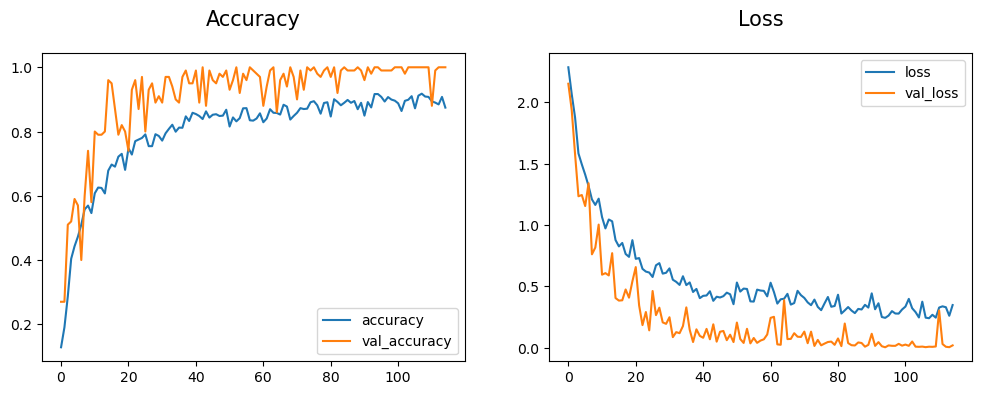

In [19]:
DenseNet201_history = compile_and_fit_model(DenseNet201_modell)

In [21]:
DenseNet201_modell.save("image_classification_leapGestRecog_DenseNet201_modell.keras")


## efficientnet_v2

In [4]:
pretrained_efficientnet_v2_base=tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    pooling="avg"
)
pretrained_efficientnet_v2_base.trainable = False

efficientnet_v2_modell = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input),
    pretrained_efficientnet_v2_base,
    layers.Dense(512, activation="relu"),

    layers.Dense(512, activation="relu"),
    
    layers.Dense(512, activation="relu"),
    
    layers.Dense(512, activation="relu"),
    
    layers.Dense(9, activation="softmax")
])
efficientnet_v2_modell.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,779,817 (83.08 MB)

 Trainable params: 1,448,457 (5.53 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [10]:
efficientnet_v2_history = compile_and_fit_model(efficientnet_v2_modell)

Epoch 1/150


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 608s 4s/step - accuracy: 0.1918 - loss: 2.1014 - val_accuracy: 0.1845 - val_loss: 2.0270 - learning_rate: 0.0010
Epoch 2/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 858s 6s/step - accuracy: 0.2168 - loss: 2.0334 - val_accuracy: 0.2618 - val_loss: 1.9603 - learning_rate: 0.0010
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 950s 7s/step - accuracy: 0.2486 - loss: 1.9654 - val_accuracy: 0.2532 - val_loss: 1.9142 - learning_rate: 0.0010
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 952s 7s/step - accuracy: 0.2558 - loss: 1.9626 - val_accuracy: 0.3004 - val_loss: 1.8843 - learning_rate: 0.0010
Epoch 5/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 939s 7s/step - accuracy: 0.2509 - loss: 1.9601 - val_accuracy: 0.2661 - val_loss: 1.8986 - learning_rate: 0.0010
Epoch 6/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 939s 7s/step - accuracy: 0.2407 - loss: 1.9509 - val_accuracy: 0.3262 - val_loss: 1.8345 - learning_rate: 0.0010
Epoch 7/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 947s 7s/step - accuracy: 0.2702 - loss: 1.9717 

133/133 ━━━━━━━━━━━━━━━━━━━━ 934s 7s/step - accuracy: 0.3405 - loss: 1.7929 - val_accuracy: 0.3219 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 45/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 925s 7s/step - accuracy: 0.3386 - loss: 1.7965 - val_accuracy: 0.3906 - val_loss: 1.7249 - learning_rate: 0.0010
Epoch 46/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 920s 7s/step - accuracy: 0.3413 - loss: 1.7989 - val_accuracy: 0.3691 - val_loss: 1.6970 - learning_rate: 0.0010
Epoch 47/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 932s 7s/step - accuracy: 0.3425 - loss: 1.7912 - val_accuracy: 0.3948 - val_loss: 1.7479 - learning_rate: 0.0010
Epoch 48/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 923s 7s/step - accuracy: 0.3479 - loss: 1.7759 - val_accuracy: 0.3863 - val_loss: 1.7113 - learning_rate: 0.0010
Epoch 49/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 923s 7s/step - accuracy: 0.3359 - loss: 1.7748 - val_accuracy: 0.3519 - val_loss: 1.7048 - learning_rate: 0.0010
Epoch 50/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 927s 7s/step - accuracy: 0.3459 - loss: 1

KeyboardInterrupt: 

In [ ]:
score =efficientnet_v2_modell.evaluate(testing_ds, steps = len(testing_ds)/BATCH_SIZE, verbose = 0)
print('test loss:', score[0])
print('test accuracy:', score[1])